# This notebook tries to improve an existing classification model using yolo to crop the image before predicting the class


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/optimize_classification_with_yolo.ipynb)

This notebook presents :
* Downloading and study of the average size of a dog in the Stanford dataset
* Processing of yolo outputs
* Make a function that manage a photo to optimize the predicton

## Connect to google drive, import important data and clone github repo to get access to yolo funcitons

In [1]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
inputs					 models		       pngs
metadata_writer_for_image_classifier.py  P6-presentation.pptx


In [2]:
import os
import re
from bs4 import BeautifulSoup
import numpy as np
import tensorflow as tf

!git clone https://github.com/Jeremynadal33/classify_stanford_dogs.git
!python /content/classify_stanford_dogs/yolo_functions.py

Cloning into 'classify_stanford_dogs'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 119 (delta 64), reused 20 (delta 5), pack-reused 0
Receiving objects: 100% (119/119), 7.27 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (64/64), done.
2021-03-09 16:28:26.433088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
if os.path.exists('/content/classify_stanford_dogs/yolo_functions.py'):
  %run /content/classify_stanford_dogs/yolo_functions.py
  print('yolo_functions loaded')
else:
  print('WARNING : please download or clone this gituhub repo : https://github.com/Jeremynadal33/classify_stanford_dogs.git')

yolo_functions loaded


## Download annotations from [Stanford](http://vision.stanford.edu/aditya86/ImageNetDogs/) 

In [8]:
def download_from_url(url, target_path = 'inputs/', keep_download = True, overwrite_download = False):
  import os
  import tarfile
  import requests
  '''Download file or data from url. 
  url (string): path to dataset
  target_path (string, optional): directory path to write download data. Default is inputs/
  keep_download (boolean, optional): wether to keep the the download file after extraction. Default is True
  overwrite_download (boolean, optional): wether to overwrite the file if it exists. Default is False.'''

  assert url != '' and url != None, 'Please, enter correct url'
  
  filename = os.path.basename(url)
  file_location = target_path + filename

  os.makedirs(target_path, exist_ok=True)
 
  if os.path.exists(file_location) and not overwrite_download:
    print("File already exists at {}. Use: 'overwrite_download=True' to overwrite download".format(file_location))
    tarf = tarfile.open(file_location, 'r')
    tarf.extractall(target_path)
    tarf.close()
		
    return
  print('Downloading file from {} to {}.'.format(url,file_location))
	# Download
  with open(file_location, 'wb') as f:
    with requests.get(url, allow_redirects=True, stream=True) as resp:
      for chunk in resp.iter_content(chunk_size = 512):  #chunk_size in bytes
        if chunk:
          f.write(chunk)

  print("Finished downloading.")
  print("Extracting the file now ...")
  tarf = tarfile.open(file_location, 'r')
  tarf.extractall(target_path)
  tarf.close()
  
  if not keep_download:
    os.remove(file_location)


  return '1'

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
download_from_url(url, input_dir, keep_download=False)

Finished downloading.
Extracting the file now ...


'1'

## Checking that everything is ready and extracting bounded boxes from file before getting the average size 

In [4]:
annotation_dir = input_dir + 'Annotation/'
path = annotation_dir + os.listdir(annotation_dir)[0] + '/' + os.listdir(annotation_dir + os.listdir(annotation_dir)[0])[0]
os.path.exists(path)

True

In [5]:
def extract_info(annotation_path, info='bndbox'):
  assert os.path.exists(annotation_path), 'File {} doesnot exist'.format(annotation_path)

  file = open(annotation_path, 'r')
  text = file.read()
  soup = BeautifulSoup(text,'lxml')

  if info == 'bndbox': 
    return int(soup.annotation.bndbox.xmin.text), int(soup.annotation.bndbox.ymin.text), int(soup.annotation.bndbox.xmax.text), int(soup.annotation.bndbox.ymax.text)
  elif info == 'specie':
    return soup.find('name').text



extract_info(path, info= 'specie')

'borzoi'

In [59]:
num_max = 1000
num = 0

heights = []
widths = []
while num < num_max:
  for fold in os.listdir(annotation_dir):
    for file in os.listdir(annotation_dir+'/'+fold):
      x1, y1, x2, y2 = extract_info(annotation_dir + '/' + fold + '/' + file)
      heights.append(y2-y1)
      widths.append(x2-x1)
      num += 1


In [60]:
print('Over {} images, the average bounded box for dogs in the Stanford dataset is ({},{})'.format(num_max, round(np.mean(widths)), round(np.mean(heights))))


Over 1000 images, the average bounded box for dogs in the Stanford dataset is (289,298)


## Importing and preparing important information for yolo model

In [6]:
yolo_path = model_dir + 'yolov3_model.h5'

if os.path.exists(yolo_path):
    print('model exists, loading')
    yolo = load_model(yolo_path)
else:
    print('model doesnt exists, creating. If you dont have the weights, please download them at : https://pjreddie.com/yolo/' )
    # define the model
    yolo = make_yolov3_model()
    # load the model weights
    weight_reader = WeightReader(model_dir+'yolov3.weights')
    # set the model weights into the model
    weight_reader.load_weights(model)
    # save the model to file
    yolo.save(model_dir+'yolov3_model.h5')

model exists, loading


In [7]:
#yolov3 class names
yolo_labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# anchors are the predefine sizes of the bounded boxes for yolov3
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

#input_dims for yolo model
input_w, input_h = 416, 416

# define the probability threshold for detected objects
class_threshold = 0.3

## Using yolo model on test img and comparing it with dog boxes

In [8]:
# Fetching image and annotations from files
# Pb with 3, 5 and 2, 5
specie_nb = 3
img_nb = 5
species = os.listdir(input_dir+'sep_images/train')

img = input_dir+'sep_images/train/' + species[specie_nb]+'/'+os.listdir(input_dir+'sep_images/train/'+species[specie_nb])[img_nb]
annotation = annotation_dir + species[specie_nb] + '/' + os.listdir(annotation_dir + species[specie_nb])[img_nb]

In [25]:
def predict_boxes(path, yolo, labels,
                  display = False,
                 yolo_threshold = 0.4, yolo_input=(416,416), anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]):
  image, image_w, image_h = load_image_pixels(path, yolo_input)
  # make prediction
  yolo_pred = yolo.predict(image)

  boxes = list()
  for i in range(len(yolo_pred)):
    # decode the output of the network
    boxes += decode_netout(yolo_pred[i][0], anchors[i], yolo_threshold, yolo_input[0], yolo_input[1])
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, yolo_input[0], yolo_input[1])
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, yolo_threshold)
  # summarize what we found
  if display : 
    for i in range(len(v_boxes)):
      print(v_labels[i], v_scores[i])
  return v_boxes, v_labels, v_scores

In [79]:
#get prediction : we may have something other than dog but we will not have the true bounded box for those
boxes, pred_labels, scores = predict_boxes(img, yolo, yolo_labels)

dog 99.47401881217957
person 51.9630491733551


In [60]:
#Get the true box
t_x1, t_y1, t_x2, t_y2 = extract_info(annotation)
t_width, t_height = t_x2 - t_x1, t_y2 - t_y1

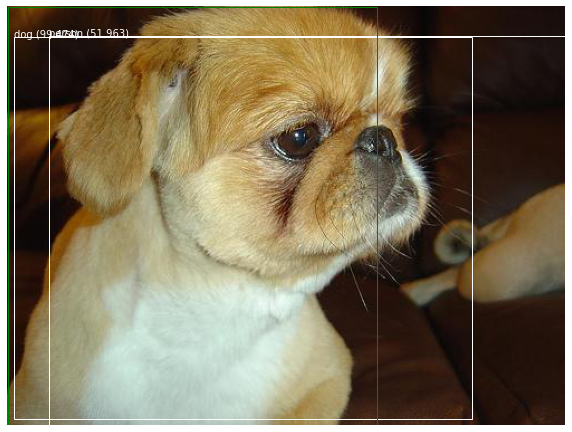

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread(img))
# get the context for drawing boxes
ax = plt.gca()
# plot each box
for i in range(len(boxes)):
  box = boxes[i]
  # get coordinates
  y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
  # calculate width and height of the box
  width, height = x2 - x1, y2 - y1
  # create the shape
  rect = Rectangle((x1, y1), width, height, fill=False, color='white')
  # draw the box
  ax.add_patch(rect)
  # draw text and score in top left corner
  label = "%s (%.3f)" % (pred_labels[i], scores[i])
  plt.text(x1, y1, label, color='white')

#Placing true box 
t_rect = Rectangle((t_x1, t_y1), t_width, t_height, fill=False, color='green')
ax.add_patch(t_rect)

plt.axis('off')

plt.show()

## Now lets crop those images to yolo bounded box predictions (which appears better than "ground truth" given by Stanford) before feeding it to the trained classification model

In [119]:
def crop(img, x1, y1, x2, y2, CLAHE = False):
  image = plt.imread(img)
  if CLAHE : image = CLAHE_rgb(image)
  shape = image.shape

  x1 = max(x1, 0)
  y1 = max(y1, 0)
  x2 = min(x2,shape[1])
  y2 = min(y2,shape[0])
  
  return tf.image.crop_to_bounding_box(
    image, y1, x1 , y2-y1, x2-x1
)

dog 99.47401881217957
person 51.96296572685242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


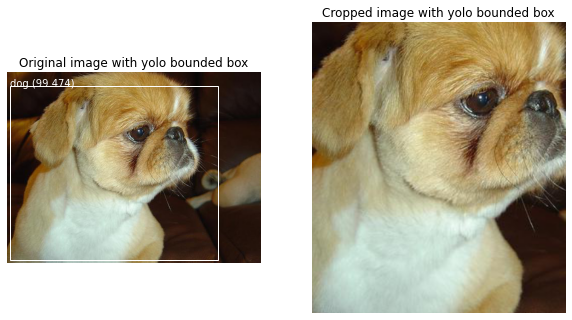

In [12]:
boxes, pred_labels, scores = predict_boxes(img, yolo, yolo_labels)

if 'dog' not in pred_labels :
  print('WARNING : yolo did not detect any dog')

fig = plt.figure(figsize=(10,20))
plt.subplot(1,2,1)

plt.imshow(plt.imread(img))
# get the context for drawing boxes
ax = plt.gca()
# plot each box
for i in range(len(boxes)):
  if pred_labels[i]=='dog':
    box = boxes[i]
    # get coordinates
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='white')
    # draw the box
    ax.add_patch(rect)
    # draw text and score in top left corner
    label = "%s (%.3f)" % (pred_labels[i], scores[i])
    plt.text(x1, y1, label, color='white')
plt.axis('off')

plt.subplot(1,2,2)
image = tf.keras.preprocessing.image.smart_resize(crop(img, x1, y1, x2, y2 )/255,(442,386))
plt.imshow(image)
plt.axis('off')


ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.title.set_text('Original image with yolo bounded box')
ax2.title.set_text('Cropped image with yolo bounded box')
plt.show()

In [13]:
model_path = model_dir + 'final_1.h5'
input_shape = (442, 386,3)

if os.path.exists(model_path):
    print('model exists, loading')
    clf_model = load_model(model_path)
    dog_labels = open(model_dir+ 'dog_labels.txt').read().split('\n')[:-1]
else:
    print('model doesnt exists' )

model exists, loading


Dog is  Pekinese


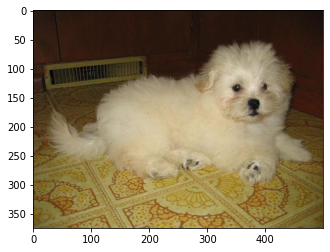

In [98]:
specie_nb = 3
img_nb = 2
species = os.listdir(input_dir+'sep_images/train')

img = input_dir+'sep_images/train/' + species[specie_nb]+'/'+os.listdir(input_dir+'sep_images/train/'+species[specie_nb])[img_nb]

print('Dog is ', dog_labels[specie_nb])
plt.imshow(plt.imread(img))

In [126]:
import cv2
def CLAHE_rgb(img): 
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  new = np.zeros(img.shape, dtype = float)
  new[:,:,0] = clahe.apply(img[:,:,0])
  new[:,:,1] = clahe.apply(img[:,:,1])
  new[:,:,2] = clahe.apply(img[:,:,2])

  return new

def predict_dog(img, clf, yolo, yolo_labels, dog_labels, compare = False):
  boxes, pred_labels, scores = predict_boxes(img, yolo, yolo_labels)

  if 'dog' not in pred_labels :
    print('WARNING : yolo did not detect any dog')
    return None, None
  else : 
    for i in range(len(boxes)):
      if pred_labels[i]=='dog':
        box = boxes[i]
    
    image = tf.keras.preprocessing.image.smart_resize( crop(img, box.ymin, box.xmin, box.ymax, box.xmax, CLAHE = True) , input_shape[:-1] )
    image = tf.expand_dims(image,0)
    c_pred = clf.predict(image)[0]

    print('Model using cropped image predicted {} with {}% confidence'.format(dog_labels[np.argmax(c_pred)], round(100*np.max(c_pred),1) ))
    if compare : 
      #print('Comparing with model using original image ')
      image = tf.keras.preprocessing.image.smart_resize( CLAHE_rgb(plt.imread(img)) , input_shape[:-1] )
      image = tf.expand_dims(image,0)
      pred = clf.predict(image)[0]
      print('Model using original image predicted {} with {}% confidence'.format(dog_labels[np.argmax(pred)], round(100*np.max(pred),1) ))
    return dog_labels[np.argmax(c_pred)], dog_labels[np.argmax(pred)]

In [125]:
predict_dog(img, clf_model, yolo, yolo_labels, dog_labels, compare = True)


Model using cropped image predicted Maltese dog with 73.5% confidence
Model using original image predicted Pekinese with 81.8% confidence


('Maltese dog', 'Pekinese')

## Lets randomly select a certain number of images and compare the two models

In [127]:
num = 100
dogs = np.random.randint(0,120,num)
img_nb = np.random.randint(0,45,num) #in validation, there is at least 45 imgs
species = os.listdir(input_dir+'sep_images/validation/')

true = []
preds = []
c_preds = []

for idx in range(len(dogs)):
  img = input_dir+'sep_images/validation/' + species[dogs[idx]] + '/' + os.listdir(input_dir+'sep_images/validation/' + species[dogs[idx]])[img_nb[idx]]
  
  c_pred, pred = predict_dog(img, clf_model, yolo, yolo_labels, dog_labels, compare = True)
  
  if c_pred != None : 
    true.append( dog_labels[ dogs[idx] ] )
    preds.append( pred )
    c_preds.append( c_pred )
    


Model using cropped image predicted Toy terrier with 94.9% confidence
Model using original image predicted Toy terrier with 99.8% confidence
Model using cropped image predicted Kerry blue terrier with 99.6% confidence
Model using original image predicted Kerry blue terrier with 99.9% confidence
Model using cropped image predicted Collie with 44.8% confidence
Model using original image predicted Border collie with 66.8% confidence
Model using cropped image predicted Labrador retriever with 40.0% confidence
Model using original image predicted Kelpie with 98.6% confidence
Model using cropped image predicted Redbone with 97.2% confidence
Model using original image predicted Redbone with 95.5% confidence
Model using cropped image predicted Leonberg with 62.1% confidence
Model using original image predicted Leonberg with 99.9% confidence
Model using cropped image predicted Beagle with 86.5% confidence
Model using original image predicted Beagle with 92.0% confidence
Model using cropped imag

In [128]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true,preds,normalize=True))
print(accuracy_score(true,c_preds,normalize=True))
print(accuracy_score(preds,c_preds,normalize=True))

0.12903225806451613
0.10752688172043011
0.7311827956989247
